## SDSS Data

This script explores the data of the spPlate and spZbest fits files. 

1. **Defining the input parameters**
2. **Reading the file**
3. **Plotting the spectrum**
4. **Pre-processing the data**

Data: 07th Oct, 2019. <br>
Author: Soumya Shreeram <br>
Script adapted from: Anand Raichoor

In order to run this script, you would need to download these two files in a folder "**Data**" within your the working directory. 

1. Example of a [spPlate file](https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/9003/spPlate-9003-57488.fits )
2. Example of a [spZbest file](https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/9003/v5_10_0/spZbest-9003-57488.fits)


In [8]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
from astropy.convolution import convolve, Box1DKernel

import matplotlib
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

## 1. Defining the input parameters

In [9]:
plate = 9003    # 4-digit plate number
mjd   = 57488   # 5-digit MJD
fiber = 120     # fibre no. (total 1000)
run2d = 2       # ?

# setting the right path for the directory with the data
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "Data")

## 2. Reading the file

Functions for reading useful information from the spPlate and spZbest fits files. 

In [14]:
def setName(filetype, plate, mjd):
    file_name = filetype+'-'+str(plate)+'-'+str(mjd)+'.fits'
    data_file = os.path.join(data_dir, file_name)
    return data_file

def readSpPlate(plate, mjd):
    """
    Function to read the useful headers and data from spPlate fits file
    @param place :: 4-digit plate number
    @param mjd :: 5-digit MJD
    
    @returns wavelength, bunit, flux, ivar (refer comments for individual meanings)
    """
    # opens the file
    hdu     = fits.open(setName('spPlate', plate, mjd))        
    
    c0      = hdu[0].header['coeff0']   # Central wavelength (log10) of first pixel
    c1      = hdu[0].header['coeff1']   # Log10 dispersion per pixel
    npix    = hdu[0].header['naxis1']   # WIDTH (TOTAL!
    wavelength    = 10.**(c0 + c1 * np.arange(npix))
    bunit   = hdu[0].header['bunit']    # Units of flux

    flux    = hdu[0].data               # Flux in units of 10^-17^ erg/s/cm^2^/Ang
    ivar    = hdu[1].data               # Inverse variance (1/sigma^2^) for HDU 0
    hdu.close()
    return wavelength, bunit, flux, ivar

def readspZbest(plate, mjd):
    """
    Function to read the useful headers and data from spZbest fits file
    @param place :: 4-digit plate number
    @param mjd :: 5-digit MJD
    
    @returns wavelength, b
    """
    hdu     = fits.open(setName('spZbest', plate, mjd))        
    
    zspec   = hdu[1].data['Z']          # best-fit spectroscopic redshift
    zclass  = hdu[1].data['CLASS']      # best-fit spectral class
    rchi2   = hdu[1].data['RCHI2']      # best-fit reduced chi2
    zwarn   = hdu[1].data['ZWARNING']   # warning flag
    synflux = hdu[2].data               # best-fit spectrum
    hdu.close()
    return zspec, zclass, rchi2, zwarn, synflux

Calling the functions and reading the data

In [17]:
[wave, bunit, flux, ivar] = readSpPlate(plate, mjd)
[zspec, zclass, rchi2, zwarn, synflux] = readspZbest(plate, mjd)

## 3. Plotting the spectrum

In [36]:
def setLabel(ax, xlabel, ylabel, title, xlim, ylim):
    """
    Function defining plot properties
    @param ax :: axes to be held
    @param xlabel, ylabel :: labels of the x-y axis
    @param title :: title of the plot
    @param xlim, ylim :: x-y limits for the axis
    """
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend()
    ax.grid(True)
    ax.set_title(title, fontsize=18)
    return    

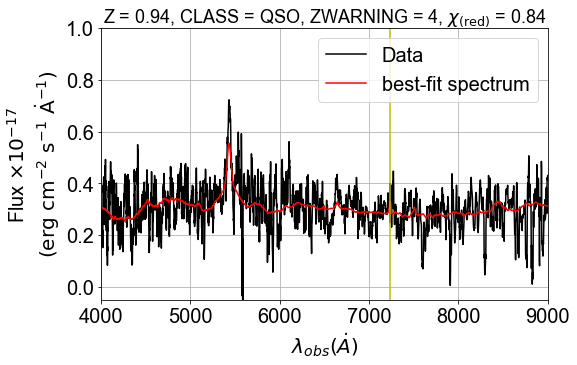

In [37]:
fig,ax = plt.subplots(figsize=(8,5))

# we smooth with 50 pixels
tmpflux    = convolve(flux[fiber-1,:] * (ivar[fiber-1,:] > 0), Box1DKernel(11))
tmpsynflux = convolve(synflux[fiber-1,:], Box1DKernel(11))

ax.plot(wave, tmpflux, 'k', label='Data')
ax.plot(wave, tmpsynflux, 'r', label='best-fit spectrum')
ax.plot(3727*(1+zspec[fiber-1]+np.zeros(2)),ylim,color='y')

xlabel = r'$\lambda_{obs} (\dot{A})$'
ylabel = r'Flux $\times 10^{-17}$'+'\n'+r'$\rm{(erg\ cm^{-2}\ s^{-1}\ \dot{A}^{-1})}$'
title = r'Z = %.2f, CLASS = %s, ZWARNING = %d, $\chi_{\rm(red)}$ = %.2f'%(zspec[fiber-1], zclass[fiber-1], zwarn[fiber-1], rchi2[fiber-1])
ylim = [-0.05,1.00]
xlim = [4000, 9000]

setLabel(ax, xlabel, ylabel, title, xlim, ylim)

## 4. Pre-processing the data